# LIME AND AIF360 for generating explanations of model predictions

In [2]:
from __future__ import print_function
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import Markdown,display

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler

In [85]:
from aif360.datasets import BinaryLabelDataset
from aif360.datasets.adult_dataset import AdultDataset
from aif360.metrics.binary_label_dataset_metric import BinaryLabelDatasetMetric
from aif360.metrics.classification_metric import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

In [103]:
from aif360.datasets.lime_encoder import LimeEncoder
import lime

## Bias detection and mitigation

In [92]:
np.random.seed(1)
dataset_orig=AdultDataset()
dataset_orig_train,dataset_orig_test=dataset_orig.split([0.7],shuffle=True)

In [203]:
scaler=StandardScaler().fit(dataset_orig_train.features)
dataset_orig_train.features=scaler.transform(dataset_orig_train.features)
dataset_orig_test.features=scaler.transform(dataset_orig_test.features)

In [204]:
dataset_df=dataset_orig_train.convert_to_dataframe()[0]
dataset_df.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
42093,1.922382,-0.051168,1.0,0.0,-0.147624,-0.220478,-0.073497,-0.180053,-0.272359,0.598088,...,-0.060646,-0.017777,-0.04501,-0.036881,-0.021035,-0.021035,0.306354,-0.040564,-0.023853,0.0
31739,1.317618,-2.014006,1.0,1.0,-0.147624,-0.220478,-0.073497,-0.180053,-0.272359,0.598088,...,-0.060646,-0.017777,-0.04501,-0.036881,-0.021035,-0.021035,0.306354,-0.040564,-0.023853,0.0
10773,-0.194291,-2.014006,1.0,1.0,-0.147624,-0.220478,1.591412,-0.180053,-0.272359,0.598088,...,-0.060646,-0.017777,-0.04501,-0.036881,-0.021035,-0.021035,0.306354,-0.040564,-0.023853,0.0
15850,-1.479414,-0.443736,0.0,1.0,-0.147624,-0.220478,-0.323233,-0.180053,-0.272359,0.598088,...,-0.060646,-0.017777,-0.04501,-0.036881,-0.021035,-0.021035,0.306354,-0.040564,-0.023853,0.0
40645,-0.496673,0.733967,1.0,1.0,-0.147624,-0.220478,0.342730,-0.180053,-0.272359,0.598088,...,-0.060646,-0.017777,-0.04501,-0.036881,-0.021035,-0.021035,0.306354,-0.040564,-0.023853,1.0


In [205]:
# 自动获得 privileged_groups和unprivilged_groups
def get_attributes(dataset,idx):
#     assert idx<len(dataset.protected_attribute_names)
    attr_name=dataset.protected_attribute_names[idx]
    attr_idx=dataset.protected_attribute_names.index(attr_name)
    priv_val=dataset.privileged_protected_attributes[attr_idx][0]
    unpriv_val=dataset.unprivileged_protected_attributes[attr_idx][0]
    privileged_groups=[{attr_name:priv_val}]
    unprivileged_groups=[{attr_name:unpriv_val}]
    return privileged_groups,unprivileged_groups

train_privileged_groups,train_unprivileged_groups=get_attributes(dataset_orig_train,0)
test_privileged_groups,test_unprivileged_groups=get_attributes(dataset_orig_test,0)

In [206]:
# dataset level bias metrics
# - mean difference
# - disparate impact
def dataset_metrics(dataset,
                   unprivileged_groups,
                   privileged_groups):
    metric_dataset=BinaryLabelDatasetMetric(dataset,
                                           unprivileged_groups=train_unprivileged_groups,
                                           privileged_groups=train_privileged_groups)
    metrics=OrderedDict()
    metrics['Mean difference']=metric_dataset.mean_difference()
    metrics['Disparate impact']=metric_dataset.disparate_impact()
    return metrics

In [207]:
# classifier based metrics
def classification_metrics(dataset,
                          dataset_pred,
                          unprivileged_groups,
                          privileged_groups):
    metric_classifier=ClassificationMetric(dataset,
                                          dataset_pred,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups)
    metrics=OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(metric_classifier.true_positive_rate()+
                                             metric_classifier.true_negative_rate())
    metrics["Statistical parity difference"] = metric_classifier.statistical_parity_difference()
    metrics["Disparate impact"] = metric_classifier.disparate_impact()
    metrics["Average odds difference"] = metric_classifier.average_odds_difference()
    metrics["Equal opportunity difference"] = metric_classifier.equal_opportunity_difference()
    metrics["Theil index"] = metric_classifier.theil_index()
    return metrics

In [208]:
metric_orig_Train=dataset_metrics(dataset_orig_train,
                             privileged_groups=train_privileged_groups,
                             unprivileged_groups=train_unprivileged_groups)
metric_orig_Test=dataset_metrics(dataset_orig_test,
                          privileged_groups=test_privileged_groups,
                          unprivileged_groups=test_unprivileged_groups)

In [209]:
# print the metrics
def metrics_print(metrics):
    for i in range(len(metrics)):
        item=list(metrics.items())[i][0]
        display(Markdown('#### %s'%item))
        print(metrics[item])

In [210]:
metrics_print(metric_orig_Test)

#### Mean difference

-0.09709386740311857


#### Disparate impact

0.627876156298822


### Transform data using Re-weighing algorithm

In [211]:
RW=Reweighing(unprivileged_groups=train_unprivileged_groups,
             privileged_groups=train_privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train=RW.transform(dataset_orig_train)
dataset_transf_train=dataset_orig_train.align_datasets(dataset_transf_train)

dataset_transf_test=RW.transform(dataset_orig_test)
dataset_transf_test=dataset_orig_test.align_datasets(dataset_transf_test)

In [212]:
metric_transf_train=dataset_metrics(dataset_transf_train,
                                   unprivileged_groups=train_unprivileged_groups,
                                   privileged_groups=train_privileged_groups)
metrics_print(metric_transf_train)

#### Mean difference

2.7755575615628914e-17


#### Disparate impact

1.0000000000000002


In [213]:
metric_transf_test=dataset_metrics(dataset_transf_test,
                                   unprivileged_groups=train_unprivileged_groups,
                                   privileged_groups=train_privileged_groups)
metrics_print(metric_transf_test)

#### Mean difference

0.01298977595547382


#### Disparate impact

1.0527650295069613


### Train a classifier on dataset_transf_train and evaluated on dataset_transf_test

In [214]:
dataset=dataset_transf_train.copy()
X_train=dataset.features
y_train=dataset.labels.ravel()
lr_transf_mod=LogisticRegression().fit(X_train,y_train,sample_weight=dataset.instance_weights)

In [215]:
num_thresh=50
thresh_arr=np.linspace(0.01,0.99,num_thresh)
dataset_transf_test_pred=dataset_transf_test.copy(deepcopy=True)

X_test=dataset_transf_test_pred.features
y_test=dataset_transf_test.labels

pos_ind=np.where(lr_transf_mod.classes_==dataset_transf_test_pred.favorable_label)[0][0]

y_pred_score=lr_mod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
dataset_transf_test_pred.scores=y_pred_score

In [216]:
acc_arr=[]
mean_diff=[]
disp_imp_dataset=[]
bal_acc=[]
stat_par_diff=[]
disp_imp_cls=[]
avg_odds_diff=[]
eq_opp_diff=[]
theil_indx=[]
for thresh in tqdm(thresh_arr):
    fav_ind=dataset_transf_test_pred.scores>thresh
#     print(sum(fav_ind))
    dataset_transf_test_pred.labels[fav_ind]=dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_ind]=dataset_transf_test_pred.unfavorable_label
    
    dataset_metric=dataset_metrics(dataset_transf_test_pred,
                                  unprivileged_groups=test_unprivileged_groups,
                                  privileged_groups=test_privileged_groups)
    classified_metric=classification_metrics(dataset_transf_test,
                                            dataset_transf_test_pred,
                                            unprivileged_groups=test_unprivileged_groups,
                                            privileged_groups=test_privileged_groups)
    acc_arr.append(accuracy_score(y_test,dataset_transf_test_pred.labels))
    mean_diff.append(dataset_metric['Mean difference'])
    disp_imp_dataset.append(dataset_metric['Disparate impact'])
    bal_acc.append(classified_metric['Balanced accuracy'])
    stat_par_diff.append(classified_metric['Statistical parity difference'])
    disp_imp_cls.append(classified_metric['Disparate impact'])
    avg_odds_diff.append(classified_metric['Average odds difference'])
    eq_opp_diff.append(classified_metric['Equal opportunity difference'])
    theil_indx.append(classified_metric['Theil index'])
#     metrics_print(dataset_metric)
#     metrics_print(classified_metric)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.65it/s]


In [217]:
best_thresh_arr_ind=np.where(bal_acc==np.max(bal_acc))[0][0]
thresh_arr_best=thresh_arr[best_thresh_arr_ind]
best_bal_acc=bal_acc[best_thresh_arr_ind]
disp_imp_at_best_bal_acc=np.abs(1.0-np.array(disp_imp_cls))[best_thresh_arr_ind]
avg_odds_diff_at_best_bal_acc=avg_odds_diff[best_thresh_arr_ind]
print("Threshold corresponding to Best balance accuracy: %6.4f" %thresh_arr_best)
print("Best balance accuracy: %6.4f"%best_bal_acc)
print("Corresponding abs(1-disparate impact) value: %6.4f" % np.abs(1.0-np.array(disp_imp_at_best_bal_acc)))
print("Corresponding average odds difference value: %6.4f" % avg_odds_diff_at_best_bal_acc)

Threshold corresponding to Best balance accuracy: 0.1900
Best balance accuracy: 0.8243
Corresponding abs(1-disparate impact) value: 0.9300
Corresponding average odds difference value: -0.0233


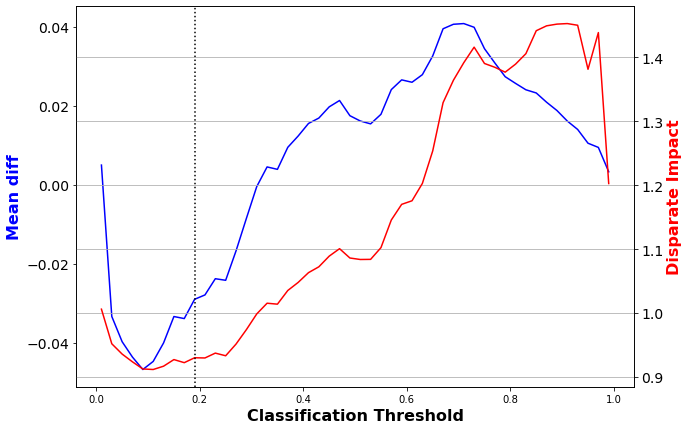

In [218]:
def plot_metrics(metricLabel1,metric1,metricLabel2,metric2):
    fig,ax1=plt.subplots(figsize=(10,7))
    ax1.plot(thresh_arr,metric1,color='b')
    ax1.set_xlabel('Classification Threshold',fontsize=16,fontweight='bold')
    ax1.set_ylabel(metricLabel1,fontsize=16,fontweight='bold',color='b')
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2=ax1.twinx()
    ax2.plot(thresh_arr,metric2,color='r')
    ax2.set_ylabel(metricLabel2,fontsize=16,fontweight='bold',c='r')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    
    ax2.axvline(thresh_arr_best,color='k',linestyle=':')
    ax2.grid(True)
plot_metrics('Mean diff',mean_diff,'Disparate Impact',disp_imp_dataset)

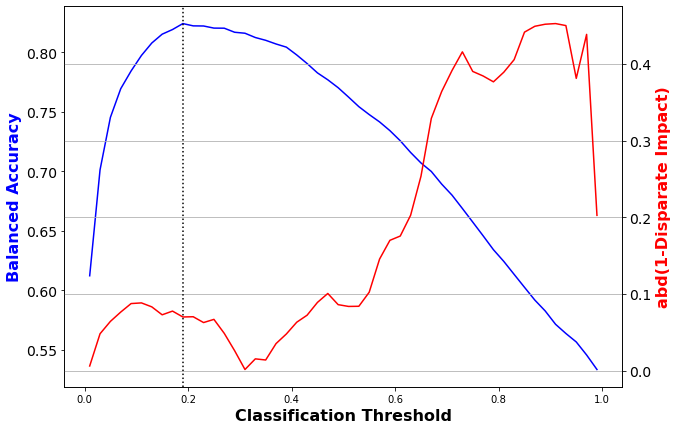

In [219]:
plot_metrics('Balanced Accuracy',bal_acc,'abd(1-Disparate Impact)',np.abs(1.0-np.array(disp_imp_cls)))

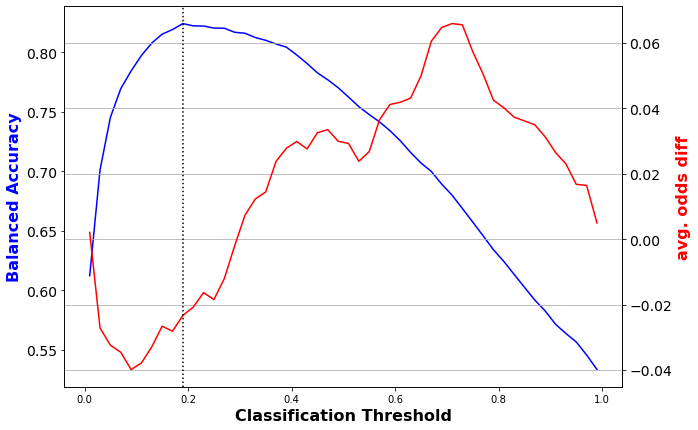

In [220]:
plot_metrics('Balanced Accuracy',bal_acc,'avg. odds diff',avg_odds_diff)

## Use LIME to generate explanations for predictions made using the learned classifier

### Working on original dataset

In [221]:
np.random.seed(1)
dataset_orig=AdultDataset()
dataset_orig_train,dataset_orig_test=dataset_orig.split([0.7],shuffle=True)


In [222]:
scaler=StandardScaler().fit(dataset_orig_train.features)
# dataset_orig_train.features=scaler.transform(dataset_orig_train.features)
# dataset_orig_test.features=scaler.transform(dataset_orig_test.features)

# 若是执行了scaler transform结果将会出错
limeData = LimeEncoder().fit(dataset_orig_train)
s_train = limeData.transform(dataset_orig_train.features)
s_test = limeData.transform(dataset_orig_test.features)

In [223]:
X_orig_train=scaler.transform(dataset_orig_train.features)

X_orig_test=scaler.transform(dataset_orig_test.features)
y_orig_train=dataset_orig_train.labels.ravel()
lr_orig_mod=LogisticRegression(solver='newton-cg').fit(X_orig_train,y_orig_train)
y_test_pred=lr_orig_mod.predict(X_orig_test)

In [224]:
acc=accuracy_score(y_test_pred,dataset_orig_test.labels)
pre=precision_score(y_test_pred,dataset_orig_test.labels)
rec=recall_score(y_test_pred,dataset_orig_test.labels)
f1=f1_score(y_test_pred,dataset_orig_test.labels.ravel())
print('prediction acc',acc)
print('prediction pre',pre)
print('prediction rec',rec)
print('prediction f1',f1)

prediction acc 0.8505933515147048
prediction pre 0.60381861575179
prediction rec 0.7432978332721263
prediction f1 0.6663374485596708


Actual label [0.]
Predicted label 0.0


<Figure size 2160x3600 with 0 Axes>

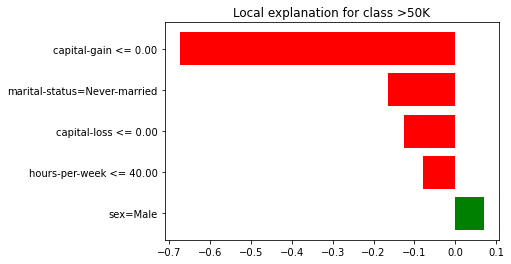

In [225]:
explainer=lime.lime_tabular.LimeTabularExplainer(s_train,
                                                class_names=limeData.s_class_names,
                                                feature_names=limeData.s_feature_names,
                                                categorical_features=limeData.s_categorical_features,
                                                categorical_names=limeData.s_categorical_names,
                                                kernel_width=3,
                                                verbose=False,
                                                discretize_continuous=True)
s_predict_fn=lambda x:lr_orig_mod.predict_proba(scaler.transform(limeData.inverse_transform(x)))# 将Lime类型数据转变回来，再用prediction Model

inst1=2
exp=explainer.explain_instance(s_test[inst1],s_predict_fn,num_features=5)
plt.figure(figsize=(30,50)) 
exp.as_pyplot_figure()
# plt.tight_layout()
print('Actual label '+str(dataset_orig_test.labels[inst1]))
print('Predicted label '+str(lr_orig_mod.predict(X_orig_test)[inst1]))

### Working on the transformed data

In [226]:
# 若是执行了scaler transform结果将会出错

dataset_transf_train=RW.transform(dataset_orig_train)
dataset_transf_train=dataset_orig_train.align_datasets(dataset_transf_train)

dataset_transf_test=RW.transform(dataset_orig_test)
dataset_transf_test=dataset_orig_test.align_datasets(dataset_transf_test)

limeData = LimeEncoder().fit(dataset_transf_train)
s_transf_train = limeData.transform(dataset_transf_train.features)
s_transf_test = limeData.transform(dataset_transf_test.features)

In [227]:
scaler_transf=StandardScaler().fit(dataset_transf_train.features)
X_transf_train=scaler_transf.transform(dataset_transf_train.features)
y_transf_train=dataset_transf_train.labels.ravel()

X_transf_test=scaler_transf.transform(dataset_transf_test.features)
y_transf_test=dataset_transf_test.labels.ravel()
# lr_mod_transf=LogisticRegression().fit(X_transf_train,y_transf_train,sample_weight=dataset_transf_train.instance_weights)
y_transf_test_pred=lr_mod_transf.predict(X_transf_test)

In [228]:
acc=accuracy_score(y_transf_test_pred,dataset_transf_test.labels)
pre=precision_score(y_transf_test_pred,dataset_transf_test.labels)
rec=recall_score(y_transf_test_pred,dataset_transf_test.labels)
f1=f1_score(y_transf_test_pred,dataset_transf_test.labels.ravel())
print('prediction acc',acc)
print('prediction pre',pre)
print('prediction rec',rec)
print('prediction f1',f1)

prediction acc 0.8494140193115648
prediction pre 0.6002386634844868
prediction rec 0.7410681399631676
prediction f1 0.6632602604252513


In [229]:
explainer=lime.lime_tabular.LimeTabularExplainer(s_transf_train,
                                                 class_names=limeData.s_class_names,
                                                 feature_names=limeData.s_feature_names,
                                                 categorical_names=limeData.s_categorical_names,
                                                 categorical_features=limeData.s_categorical_features,
                                                 kernel_width=3,
                                                 verbose=False,
                                                 discretize_continuous=True
                                                )

In [230]:
s_predict_fn=lambda x:lr_mod_transf.predict_proba(scaler_transf.transform(limeData.inverse_transform(x)))

Actual Label  0.0
Predicted Label  0.0


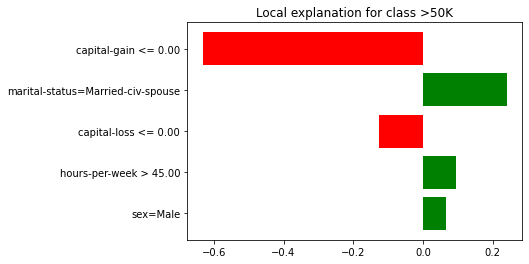

In [231]:
exp=explainer.explain_instance(s_transf_test[1],
                              s_predict_fn,
                              num_features=5)
exp.as_pyplot_figure()
print('Actual Label ',y_transf_test[3])
print('Predicted Label ',lr_mod_transf.predict(X_transf_test)[3])